In [44]:
import numpy as np 
from scipy.special import j0, y0
import matplotlib.pyplot as plt

#Helpers for Green function
def J0_2(omega,x,xref):
    return j0(omega*np.linalg.norm(x-xref,2,axis=-1))**2
    
def h0(s):
    return complex(j0(s),y0(s))

def Go_F(omega,x,y):
    return (1/4)*h0(omega*(np.linalg.norm(x-y,2,axis=-1)))*complex(0,1)

def G_F(omega,x,y,x_ref,rho):
    #Born Approximation of G_F for ponctual rho
    return omega**2*Go_F(omega,x,x_ref)*rho*Go_F(omega,x_ref,y) #+ Go_F(omega,x,y)

Time-harmonic localization - full aperture

In [45]:
#Define transducers
N = 100 
N1 = 50
N2 = 40
R0 = 100
R1 = 50 
R2 = 20
def circle_points(r, n):
    circles = []
    for r, n in zip(r, n):
        t = np.linspace(0, 2*np.pi, n)
        x = r * np.cos(t)
        y = r * np.sin(t)
        circles.append(np.c_[x, y])
    return circles
transducers_circle = circle_points([R0],[N])[0]
transducers_linear_1 = np.vstack((np.linspace(-R1/2,R1/2,N1),np.zeros(N1))).T
transducers_linear_2 = np.vstack((np.linspace(-R2/2,R2/2,N2),np.zeros(N2))).T

#Define reflectors
x_ = 5
y_ = 5
reso = 10
x_ref = np.array([10,20])
grid = np.zeros((2*reso+1,2*reso+1,2))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        grid[k,l] = np.array([x_ref[0] + (k-reso)/reso*x_ , x_ref[1] + (l-reso)/reso*y_])

x_ref_2 = np.array([0,100])
grid_2 = np.zeros((2*reso+1,2*reso+1,2))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        grid_2[k,l] = np.array([x_ref_2[0] + (k-reso)/reso*x_ , x_ref_2[1] + (l-reso)/reso*y_])
rho = 0.5

#Define frequency bandwith
omega_o = 2*np.pi
bandwith = 0.05 * omega_o
omega_resolution = 20
omegas = np.linspace(omega_o-bandwith,omega_o+bandwith,omega_resolution)

In [46]:
#Compute the dataset
U = np.ones(shape=(N,N), dtype=complex)
U1 = np.ones(shape=(N1,N1), dtype=complex)
U2 = np.ones(shape=(omega_resolution,N2,N2), dtype=complex)

for r in range(N): 
    for s in range(N):
        if s != r:
            U[r,s] = G_F(omega_o,transducers_circle[r],transducers_circle[s],x_ref,rho)
        if s ==r :
            U[r,s] = 0

for r in range(N1): 
    for s in range(N1):
        if s != r:
            U1[r,s] = G_F(omega_o,transducers_linear_1[r],transducers_linear_1[s],x_ref_2,rho)
        if s ==r :
            U1[r,s] = 0

#for i in range(omega_resolution):
#    omega = omegas[i]
#    for r in range(N2): 
#        for s in range(N2):
#            if s != r:
#                U2[i,r,s] = G_F(omega,transducers_linear_2[r],transducers_linear_2[s],x_ref_2,rho)
#            if s ==r :
#                U2[i,r,s] = 0

In [47]:
#Compute the reverse time imaging
rho_RT = np.zeros((2*reso+1,2*reso+1))
rho_RT1 = np.zeros((2*reso+1,2*reso+1))
rho_RT2 = np.zeros((2*reso+1,2*reso+1))

for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        for r in range(N): 
            for s in range(N):
                rho_RT[k,l] += Go_F(omega_o,x_local,transducers_circle[s])*omega_o**2*Go_F(omega_o,transducers_circle[r],x_local)*np.conj(U[r,s])
        rho_RT[k,l] *= (0.5/np.pi)
        x_local = grid_2[k,l]
        for r in range(N1): 
            for s in range(N1):
                rho_RT1[k,l] += Go_F(omega_o,x_local,transducers_linear_1[s])*omega_o**2*Go_F(omega_o,x_local,transducers_linear_1[r])*np.conj(U1[r,s])
        rho_RT1[k,l] *= (0.5/np.pi)
        #for i in range(omega_resolution):
        #    omega = omegas[i]
        #    for r in range(N2): 
        #        for s in range(N2):
        #            rho_RT2[k,l] += Go_F(omega,x_local,transducers_linear_2[s])*omega**2*Go_F(omega,x_local,transducers_linear_2[r])*np.conj(U2[i,r,s])
        #rho_RT2[k,l] *= (0.5/np.pi)
        

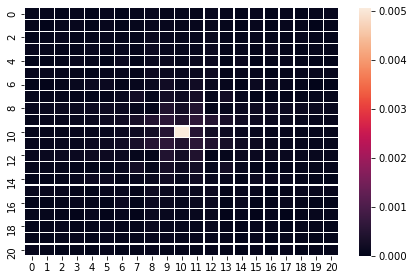

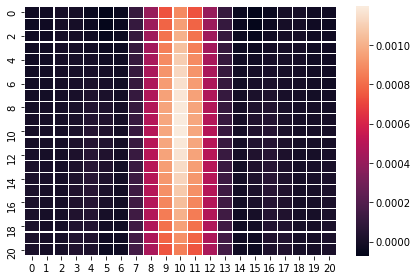

In [48]:
#Visualize the reverse time imaging
import seaborn as sns
ax = sns.heatmap(rho_RT.T, linewidth=0.1)
#ax.set_xticklabels(labels=grid[:,0,0])
#ax.set_yticklabels(labels=grid[0,:,1])
plt.tight_layout()
plt.show()
ax = sns.heatmap(rho_RT1.T, linewidth=0.1)
#ax.set_xticklabels(labels=grid_2[:,0,0])
#ax.set_yticklabels(labels=grid_2[0,:,1])
plt.tight_layout()
plt.show()


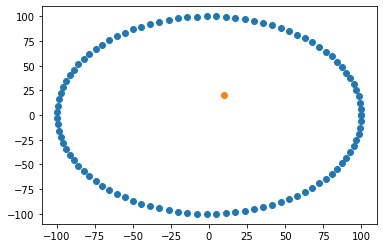

In [49]:
#Compute the KM imaging
plt.scatter(transducers_circle[:,0],transducers_circle[:,1])
plt.scatter(x_ref[0],x_ref[1])

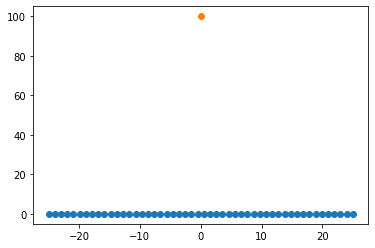

In [50]:
plt.scatter(transducers_linear_1[:,0],transducers_linear_1[:,1])
plt.scatter(x_ref_2[0],x_ref_2[1])

In [51]:
#Visualize the KM imaging

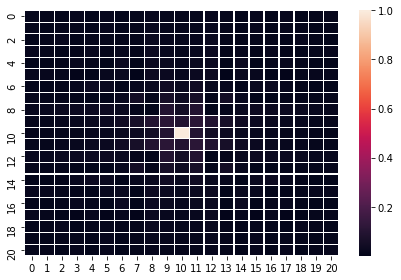

In [52]:
#Visualize theoritical function
J = np.zeros((2*reso+1,2*reso+1))
for k in range(2*reso+1):
    for l in range(2*reso+1):
        x_local = grid[k,l]
        J[k,l] = J0_2(omega_o,x_local,x_ref)
ax = sns.heatmap(J.T, linewidth=0.1)
plt.tight_layout()
plt.show()